In [ ]:
!mkdir result

In [1]:
import pickle
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import argparse
import time
from copy import deepcopy
import os

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
#CIFAR-100 다운받고 압축 풀기
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz -O /content/cifar-100-python.tar.gz
!tar -xzvf "/content/cifar-100-python.tar.gz"

# 데이터 불러오기
def unpickle(file_path):
    import pickle
    with open(file_path, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

meta = unpickle("cifar-100-python/meta")
fine_label_names = list(label.decode('UTF8')for label in meta[b'fine_label_names'])  #label list, len:100
trainset = unpickle("cifar-100-python/train")
testset = unpickle("cifar-100-python/test")

--2024-02-29 20:37:04--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘/content/cifar-100-python.tar.gz’

/content/cifar-100- 100%[===================>] 161.17M  50.2MB/s    in 3.6s    

2024-02-29 20:37:07 (45.2 MB/s) - ‘/content/cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [5]:
data = trainset[b'data']
label = trainset[b'fine_labels']

#train data를 train,validation으로 분리
train_data,val_data = train_test_split(data,test_size = 0.2,random_state = 1004)
train_label,val_label = train_test_split(label,test_size = 0.2, random_state=1004)
test_data = testset[b'data']
test_label = testset[b'fine_labels']

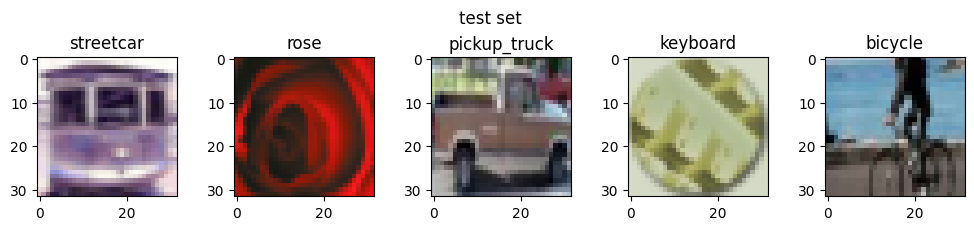

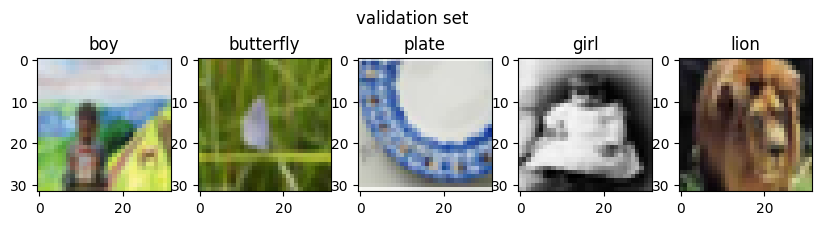

In [6]:
#testset 데이터 시각화
fig,ax = plt.subplots(1,5,figsize = (10,10))
fig.suptitle("test set",y=0.61)
fig.tight_layout()
for i in range(5):
  image = train_data[i].reshape(3,32,32).transpose(1,2,0)
  ax[i].set_title(fine_label_names[train_label[i]])
  ax[i].imshow(image)
plt.show()
#validationset 데이터 시각화
fig,ax = plt.subplots(1,5,figsize = (10,10))
fig.suptitle("validation set",y=0.61)
for i in range(5):
  image = val_data[i].reshape(3,32,32).transpose(1,2,0)
  ax[i].set_title(fine_label_names[val_label[i]])
  ax[i].imshow(image)
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class CIFAR100_dataset_to_pytorch(Dataset):
  def __init__(self,data,labels,transfrom=None):
    self.data = data.reshape(-1,3, 32, 32).transpose(0,2,3,1) #data shape 변환
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    image = self.data[idx]
    label = self.labels[idx]

    if self.transform: #transform이 주어지면 image를 transform
      image = self.transform(image)

    return image,label


In [8]:
# transtorm 정의 , 평균과 표준편차를 0.5로 설정
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = CIFAR100_dataset_to_pytorch(train_data,train_label,transform)
val_set = CIFAR100_dataset_to_pytorch(val_data,val_label,transform)

partition = {'train': train_set, 'val':val_set}

In [9]:
#int : kernel size, M : MaxPooling
cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}

In [10]:
#CNN 정의
class CNN(nn.Module):

    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()

        #activation 설정
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.TanH()
        else:
            raise ValueError("Not a valid activation function code")


        self.layers = self._make_layers(model_code, in_channels, use_bn) #layer 생성
        self.dropout_ = nn.Dropout(0.8) #overfiting 방지
        self.classifer = nn.Sequential(nn.Linear(512, 256),
                                       self.act,
                                       self.dropout_,
                                       nn.Linear(256, out_dim))
    # forward 정의
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x

    #layer 생성 정의
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            # x == 'M'이면 maxpooling layer 생성
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            # 숫자면 conv layer 생성
            else:
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)]

                # batch norm 사용할 때
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act] #activation func 적용
                in_channels = x
        return nn.Sequential(*layers)


In [11]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train() # train모드로 설정

    correct = 0 # 예측중 정답 수
    total = 0 # 전체 데이터 수
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() #gradient 초기화


        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward() #backpropagation
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1) #가장 점수가 높은 output의 data 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader) # loss 평균
    train_acc = 100 * correct / total # train 정확도
    return net, train_loss, train_acc

In [12]:
def validate(net,parition,criterion,args):
  valloader = torch.utils.data.DataLoader(partition["val"],
                                          batch_size=args.test_batch_size,
                                          shuffle=False,
                                          num_workers=2)

  net.eval() # eval()모드로 설정

  correct = 0
  total = 0
  val_loss = 0
  with torch.no_grad():
    for data in valloader:
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      outputs = net(images)

      loss = criterion(outputs, labels)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data ,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total
  return val_loss, val_acc

In [24]:
def experiment(partition, args):

    # CNN 생성
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss() # loss 계산 방법 선택
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice') # 정의된 optimizer 외 사용

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):
        ts = time.time() # 시작시간 기록
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args) # train
        val_loss, val_acc = validate(net, partition, criterion, args) # val
        te = time.time() # 종료시간 기록

        #loss 추가
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))


    # 결과 저장
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc

    # 가중치 파일
    weight_save_path = f"saved_weights_final_epoch_{args.epoch}.pth"
    torch.save(net.state_dict(), weight_save_path)

    return vars(args), result

In [29]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting["exp_name"]
    del setting["epoch"]
    del setting["test_batch_size"]

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = "./results-{}-{}.json".format(exp_name, hash_key)
    result.update(setting)
    with open(filename, "w") as f:
        json.dump(result, f)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 30

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
# name_var1 = 'lr'
# name_var2 = 'model_code'
# list_var1 = [0.0001, 0.00001]
# list_var2 = ['VGG11']


# for var1 in list_var1:
#     for var2 in list_var2:
#         setattr(args, name_var1, var1)
#         setattr(args, name_var2, var2)
#         print(args)

setting, result = experiment(partition, deepcopy(args))
save_exp_result(setting, result)

Epoch 0, Acc(train/val): 2.96/9.58, Loss(train/val) 4.52/4.31. Took 11.59 sec
Epoch 1, Acc(train/val): 6.32/13.37, Loss(train/val) 4.30/3.99. Took 11.32 sec
Epoch 2, Acc(train/val): 10.00/17.89, Loss(train/val) 4.05/3.72. Took 11.25 sec
Epoch 3, Acc(train/val): 13.64/23.90, Loss(train/val) 3.80/3.42. Took 11.41 sec
Epoch 4, Acc(train/val): 17.89/27.82, Loss(train/val) 3.55/3.18. Took 11.29 sec
Epoch 5, Acc(train/val): 21.95/26.04, Loss(train/val) 3.30/3.09. Took 11.45 sec
Epoch 6, Acc(train/val): 26.08/32.41, Loss(train/val) 3.07/2.87. Took 11.42 sec
Epoch 7, Acc(train/val): 29.84/29.86, Loss(train/val) 2.85/2.90. Took 11.41 sec
Epoch 8, Acc(train/val): 34.27/34.74, Loss(train/val) 2.62/2.71. Took 11.47 sec
Epoch 9, Acc(train/val): 38.82/36.74, Loss(train/val) 2.38/2.60. Took 11.30 sec
Epoch 10, Acc(train/val): 44.03/35.48, Loss(train/val) 2.14/2.62. Took 11.41 sec
Epoch 11, Acc(train/val): 48.71/39.44, Loss(train/val) 1.92/2.45. Took 11.10 sec
Epoch 12, Acc(train/val): 54.13/38.75, Lo

In [33]:
from google.colab import files
files.download("/content/saved_weights_final_epoch_30.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>